In [95]:
# General imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import matplotlib.pyplot as plt

In [96]:
# Training and testing folders
train_path = '../input/fruits/fruits-360_dataset_2018_05_22/fruits-360/Training/'
valid_path = '../input/fruits/fruits-360_dataset_2018_05_22/fruits-360/Validation/'

In [97]:
# Get train and test files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

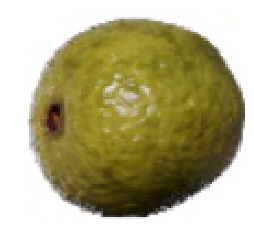

In [98]:
# Get number of classes
folders = glob(train_path + '/*')

# Display any random image
plt.imshow(plt.imread(np.random.choice(image_files)))
plt.axis('off')
plt.show()

In [99]:
# Specific imports
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [100]:
# Resize all the images to this
IMAGE_SIZE = [100, 100]
# Training config
epochs = 5
batch_size = 32

In [101]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
# Don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [102]:
# Create Model
model = Model(inputs=vgg.input, outputs=prediction)

# View structure of the model
model.summary()

# Configure model
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [103]:
# Create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  rescale=1./255,  
  preprocessing_function=preprocess_input
)

# Get label mapping of class and label number
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 9837 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

In [104]:
# Create generators for training and validation
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
)
# Fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Found 29228 images belonging to 60 classes.
Found 9837 images belonging to 60 classes.
Epoch 1/5
913/913 [==============================] - 171s 188ms/step - loss: 0.7572 - acc: 0.8058 - val_loss: 0.5146 - val_acc: 0.8354
Epoch 2/5
913/913 [==============================] - 170s 186ms/step - loss: 0.2023 - acc: 0.9412 - val_loss: 0.3539 - val_acc: 0.8959
Epoch 3/5
913/913 [==============================] - 171s 188ms/step - loss: 0.1293 - acc: 0.9599 - val_loss: 0.3366 - val_acc: 0.9027
Epoch 4/5
913/913 [==============================] - 171s 188ms/step - loss: 0.1019 - acc: 0.9664 - val_loss: 0.2759 - val_acc: 0.9202
Epoch 5/5
913/913 [==============================] - 170s 187ms/step - loss: 0.0849 - acc: 0.9732 - val_loss: 0.2600 - val_acc: 0.9273


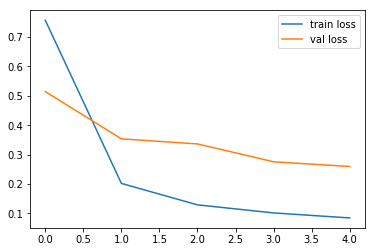

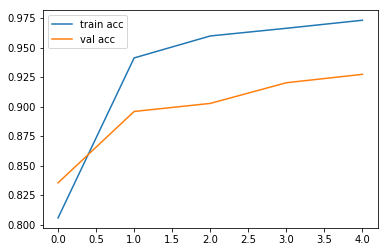

In [108]:
# Plot the train and validation loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Plot the train and validation accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [109]:
print("Final training accuracy = {}".format(r.history["acc"][-1]))
print("Final validation accuracy = {}".format(r.history["val_acc"][-1]))

Final training accuracy = 0.9731470064392382
Final validation accuracy = 0.9273208469055375


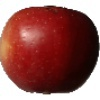

Actual class: Apple Braeburn
Predicted class: Apple Braeburn


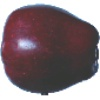

Actual class: Apple Red Delicious
Predicted class: Apple Red Delicious


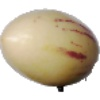

Actual class: Pepino
Predicted class: Pepino


In [130]:
# Visualizing predictions
result = np.round(model.predict_generator(valid_generator))
import random
test_files = []
actual_res = []
test_res = []
for i in range(0, 3):
  rng = random.randint(0, len(valid_generator.filenames))
  test_files.append(valid_path +  valid_generator.filenames[rng])
  actual_res.append(valid_generator.filenames[rng].split('/')[0])
  test_res.append(labels[np.argmax(result[rng])])
  
from IPython.display import Image, display
for i in range(0, 3):
  display(Image(test_files[i]))
  print("Actual class: " + str(actual_res[i]))
  print("Predicted class: " + str(test_res[i]))
  